In [23]:
# --- GLOBAL FONT SETTINGS ---
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
import os
import warnings

# 1. Define the target font name
font_name = 'Outfit'

# 2. Set Global Font Parameters (The core configuration)
# This uses the 'sans-serif' family with 'Outfit' as the primary preference.
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.sans-serif'] = [font_name, 'Arial', 'DejaVu Sans']

# 3. Font Confirmation (Skip if using an old/incompatible Matplotlib version)
try:
    # Attempt to use version-compatible methods for confirmation (which may still fail on your current version)
    # The true success relies on the manual cache clear and kernel restart.
    
    # Check if the font is in the system list (which we already confirmed with SUCCESS)
    system_fonts = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
    
    # The following line is prone to error on older versions, so we wrap it.
    # It attempts to get the current list of loaded fonts based on the system scan.
    
    # Reload font manager's font list for the check (This line caused the last error, so we guard it)
    try:
        font_manager.fontManager.ttflist = font_manager.createFontList(system_fonts)
    except AttributeError:
        pass # Silently pass if createFontList is not available

    # Check the list
    if font_name in [f.name for f in font_manager.fontManager.ttflist]:
        print(f"Global font set to '{font_name}'.")
    else:
        warnings.warn(f"Warning: Font '{font_name}' not yet confirmed by Matplotlib in this session.")

except Exception as e:
    # Catch any lingering errors, like permission issues during a scan
    warnings.warn(f"Error during font setting process: {e}")

print("Font parameters applied. Please ensure you manually clear the Matplotlib cache and restart the kernel for changes to take effect.")
# ----------------------------

Global font set to 'Outfit'.
Font parameters applied. Please ensure you manually clear the Matplotlib cache and restart the kernel for changes to take effect.


In [24]:
# Cell 1: Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import glob
from fcsparser import parse
from statannotations.Annotator import Annotator
from matplotlib.gridspec import GridSpec
import openpyxl
from openpyxl.styles import PatternFill
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("colorblind")

In [25]:
# Cell 2: Define channel mapping and folder processing function
# Define channel mapping
channel_mapping = {
    '1': 'Y585-A',
    '2': 'B525-A', '7': 'B525-A',
    '3': 'V450-A', '5': 'V450-A',
    '4': 'R660-A', '6': 'R660-A'
}

def process_folder(folder_path):
    """Process data in a single folder using its own BY4741 for correction"""
    # Get all FCS files
    fcs_files = glob.glob(os.path.join(folder_path, "*.fcs"))
    
    # Separate BY4741 and other samples
    by4741_files = [f for f in fcs_files if 'BY4741' in os.path.basename(f)]
    sample_files = [f for f in fcs_files if 'BY4741' not in os.path.basename(f)]
    
    # Process BY4741 controls - use current batch's BY4741
    by4741_data = []
    for file in by4741_files:
        meta, data = parse(file)
        by4741_data.append(data)
    
    # Combine all BY4741 data from current batch and calculate channel medians
    if by4741_data:
        by4741_combined = pd.concat(by4741_data, ignore_index=True)
        channel_medians = by4741_combined.median()
    else:
        channel_medians = pd.Series()
        print(f"Warning: No BY4741 data found in folder {folder_path}")
    
    # Process sample data
    results = {}
    for file in sample_files:
        # Parse filename to get sample info and EMS status
        filename = os.path.basename(file)
        sample_name = filename.replace('.fcs', '').replace('_EMS', '')
        is_ems = '_EMS' in filename
        
        # Extract numbers from sample name to determine primary channel
        sample_number = ''.join(filter(str.isdigit, sample_name))
        if not sample_number:
            continue
            
        primary_channel = None
        for num, channel in channel_mapping.items():
            if sample_number in num.split(','):
                primary_channel = channel
                break
        
        if not primary_channel:
            continue
        
        # Read data
        meta, data = parse(file)
        
        # Quality control: Remove cells with fluorescence below current batch BY4741 median in primary channel
        if primary_channel in channel_medians:
            threshold = channel_medians[primary_channel]
            filtered_data = data[data[primary_channel] > threshold].copy()
            
            # Background correction for all channels: subtract current batch BY4741 median
            for channel in channel_medians.index:
                if channel in filtered_data.columns:
                    filtered_data[channel] = filtered_data[channel] - channel_medians[channel]
                    # Ensure non-negative values
                    filtered_data[channel] = filtered_data[channel].clip(lower=0)
        else:
            filtered_data = data  # If no BY4741 data, skip filtering and correction
        
        # Store results
        if sample_name not in results:
            results[sample_name] = {'pre': {}, 'post': {}}
        
        ems_key = 'post' if is_ems else 'pre'
        results[sample_name][ems_key] = {
            'data': filtered_data,
            'original_count': len(data),
            'filtered_count': len(filtered_data),
            'primary_channel': primary_channel,
            'background_values': channel_medians.to_dict() if not channel_medians.empty else {}
        }
    
    return results, channel_medians

In [26]:
# Cell 3: Function to process all folders
def process_all_folders(parent_folder):
    """Process all subfolders in the parent folder"""
    all_results = {}
    folders = ['a', 'b', 'c', 'd']
    
    for folder in folders:
        folder_path = os.path.join(parent_folder, folder)
        if os.path.exists(folder_path):
            results, medians = process_folder(folder_path)
            all_results[folder] = {
                'results': results,
                'channel_medians': medians
            }
        else:
            print(f"Warning: Folder {folder_path} does not exist")
    
    return all_results

In [27]:
# Cell 4: Execute data processing
# Replace with your actual path
parent_folder = "D:/iGEM/湿实验/流式/Flow Cytometry"
all_data = process_all_folders(parent_folder)

In [28]:
# Cell 5: Statistical analysis and result organization (MODIFIED FOR T-TEST ON LOG1P DATA)
def analyze_data(all_data):
    """Analyze processed data, now using t-test on log1p-transformed values."""
    summary_data = []
    statistical_results = []
    
    for folder, data_dict in all_data.items():
        channel_medians = data_dict['channel_medians']
        results = data_dict['results']
        
        for sample_name, sample_data in results.items():
            # Get primary channel
            primary_channel = sample_data['pre'].get('primary_channel') or sample_data['post'].get('primary_channel')
            
            # Calculate cell count statistics
            pre_original = sample_data['pre']['original_count']
            pre_filtered = sample_data['pre']['filtered_count']
            post_original = sample_data['post']['original_count']
            post_filtered = sample_data['post']['filtered_count']
            
            pre_percentage = pre_filtered / pre_original * 100 if pre_original > 0 else 0
            post_percentage = post_filtered / post_original * 100 if post_original > 0 else 0
            
            summary_data.append({
                'Folder': folder,
                'Sample': sample_name,
                'Primary_Channel': primary_channel,
                'Pre_Original': pre_original,
                'Pre_Filtered': pre_filtered,
                'Pre_Percentage': pre_percentage,
                'Post_Original': post_original,
                'Post_Filtered': post_filtered,
                'Post_Percentage': post_percentage,
                'Background_Values': sample_data['pre'].get('background_values', {})
            })
            
            # Statistical analysis for each channel
            channels = ['Y585-A', 'B525-A', 'V450-A', 'R660-A']
            
            for channel in channels:
                # Use raw background-corrected values for median and FC calculation
                pre_raw_values = sample_data['pre']['data'][channel].values
                post_raw_values = sample_data['post']['data'][channel].values
                
                # --- MODIFICATION START: Log1p Transformation for T-test ---
                
                # Apply log1p transformation for the t-test (required for normal-like distribution)
                pre_log_values = np.log1p(pre_raw_values)
                post_log_values = np.log1p(post_raw_values)
                
                # --- MODIFICATION END ---
                
                # Calculate descriptive statistics (using raw values for meaningful FC)
                pre_median = np.median(pre_raw_values) if len(pre_raw_values) > 0 else np.nan
                post_median = np.median(post_raw_values) if len(post_raw_values) > 0 else np.nan
                
                # Calculate Fold Change
                if pre_median > 0 and not np.isnan(pre_median):
                    fold_change = post_median / pre_median
                    log2_fc = np.log2(fold_change)
                else:
                    fold_change = np.nan
                    log2_fc = np.nan
                
                # --- MODIFICATION: Replace Mann-Whitney U with Independent T-test on log1p data ---
                if len(pre_log_values) > 1 and len(post_log_values) > 1: # T-test needs at least 2 samples
                    try:
                        # Use ttest_ind for independent samples t-test
                        stat, p_value = stats.ttest_ind(pre_log_values, post_log_values, equal_var=False) 
                        # equal_var=False performs Welch's T-test, which is generally safer
                        
                        significance = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
                    except:
                        p_value = np.nan
                        significance = 'N/A'
                else:
                    p_value = np.nan
                    significance = 'N/A'
                
                # Get background value for current channel
                background_value = sample_data['pre'].get('background_values', {}).get(channel, np.nan)
                
                statistical_results.append({
                    'Folder': folder,
                    'Sample': sample_name,
                    'Channel': channel,
                    'Pre_Median': pre_median,
                    'Post_Median': post_median,
                    'Fold_Change': fold_change,
                    'log2_Fold_Change': log2_fc,
                    'P_Value': p_value,
                    'Significance': significance,
                    'Is_Primary': channel == primary_channel,
                    'Background_Value': background_value
                })
    
    return pd.DataFrame(summary_data), pd.DataFrame(statistical_results)

# Execute analysis
summary_df, stats_df = analyze_data(all_data)

In [34]:
# Cell 5.5: Calculate Composite Score and prepare data for model analysis (FIXED: Uses FLUOROPHORE TYPE 1-7)
print("\n--- Starting Composite Score Calculation ---")

# --- Step 1: Prepare the data structure ---
# Filter stats_df to only include Primary Channel rows
primary_stats_df = stats_df[stats_df['Is_Primary'] == True].copy()

# Add Promoter (S, R, O, T) and Fluorophore Type (1-7) columns
def extract_promoter(sample_name):
    if 'S' in sample_name: return 'S'
    if 'R' in sample_name: return 'R'
    if 'O' in sample_name: return 'O'
    if 'T' in sample_name: return 'T'
    return 'Unknown'

def extract_fluorophore_type(sample_name):
    # 使用正则表达式提取样品名中的第一个数字序列 (例如 UO1 -> 1, UR3 -> 3)
    import re
    match = re.search(r'(\d+)', sample_name)
    if match:
        return int(match.group(1))
    return np.nan

primary_stats_df['Promoter'] = primary_stats_df['Sample'].apply(extract_promoter)
primary_stats_df['Fluorophore_Type'] = primary_stats_df['Sample'].apply(extract_fluorophore_type)


# --- Step 2: Calculate Specificity Loss (S_loss) ---
# S_loss is the mean squared log2FC of non-primary channels for each sample.
specificity_loss = {}

for folder, data_dict in all_data.items():
    results = data_dict['results']
    for sample_name in results.keys():
        # Get all stats for the current sample across all channels
        sample_all_stats = stats_df[(stats_df['Sample'] == sample_name) & (stats_df['Folder'] == folder)]
        
        # Filter for non-primary channels
        non_primary_stats = sample_all_stats[sample_all_stats['Is_Primary'] == False]
        
        # Calculate Mean(log2FC^2) for loss (punishing both positive and negative non-specific changes)
        if not non_primary_stats.empty and non_primary_stats['log2_Fold_Change'].notna().any():
            mean_log2fc_sq = (non_primary_stats['log2_Fold_Change']**2).mean()
        else:
            mean_log2fc_sq = 0.0
            
        specificity_loss[(folder, sample_name)] = mean_log2fc_sq

# Map S_loss back to the primary_stats_df
primary_stats_df['S_loss'] = primary_stats_df.apply(
    lambda row: specificity_loss.get((row['Folder'], row['Sample']), np.nan), axis=1
)

# --- Step 3: Calculate Effectiveness (E) and Composite Score (S) ---

# Set weights
W_E = 10.0 # Weight for Efficacy
W_S = 1.0  # Weight for Specificity Loss

# Handle P_Value = 0 by replacing with a small number for log calculation
primary_stats_df['P_Value_Adj'] = primary_stats_df['P_Value'].replace(0, 1e-300)

# 1. Effectiveness (E): |log2FC| * (-log10(P))
primary_stats_df['Effectiveness_E'] = (
    primary_stats_df['log2_Fold_Change'].abs() * (-np.log10(primary_stats_df['P_Value_Adj']))
)

# 2. Composite Score (S): S = W_E * E - W_S * S_loss
primary_stats_df['Composite_Score_S'] = (W_E * primary_stats_df['Effectiveness_E']) - (W_S * primary_stats_df['S_loss'])

# Finalize the data table for analysis
analysis_df = primary_stats_df.rename(
    columns={'Channel': 'Primary_Physical_Channel'}
)[['Folder', 'Sample', 'Promoter', 'Fluorophore_Type', 'Primary_Physical_Channel', 'Effectiveness_E', 'S_loss', 'Composite_Score_S', 'log2_Fold_Change', 'P_Value_Adj']]

print("Analysis DataFrame generated successfully.")
print(analysis_df.head())


--- Starting Composite Score Calculation ---
Analysis DataFrame generated successfully.
   Folder Sample Promoter  Fluorophore_Type Primary_Physical_Channel  \
0       a    UO1        O                 1                   Y585-A   
6       a    UO5        O                 5                   V450-A   
10      a    UR3        R                 3                   V450-A   
13      a    UT2        T                 2                   B525-A   
18      a    UT3        T                 3                   V450-A   

    Effectiveness_E    S_loss  Composite_Score_S  log2_Fold_Change  \
0          4.040271  0.192600          40.210107          0.113467   
6        171.260190  0.079500        1712.522400          0.570867   
10       228.999120  0.217680        2289.773520          0.763330   
13        53.445353  0.044299         534.409227          0.178151   
18       181.620222  0.773852        1815.428371          0.605401   

      P_Value_Adj  
0    2.470017e-36  
6   1.000000e-300

In [31]:
# Cell 6: Create Excel output
def create_excel_output(summary_df, stats_df, output_path):
    """Create Excel output file"""
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        # Summary sheet
        summary_df.to_excel(writer, sheet_name='Sample_Summary', index=False)
        
        # Statistical results sheet
        stats_df.to_excel(writer, sheet_name='Statistical_Results', index=False)
        
        # Background values sheet
        background_data = []
        for _, row in summary_df.iterrows():
            for channel, bg_value in row['Background_Values'].items():
                background_data.append({
                    'Folder': row['Folder'],
                    'Sample': row['Sample'],
                    'Channel': channel,
                    'Background_Value': bg_value
                })
        bg_df = pd.DataFrame(background_data)
        bg_df.to_excel(writer, sheet_name='Background_Values', index=False)
        
        # Get workbook and sheets for formatting
        workbook = writer.book
        summary_sheet = workbook['Sample_Summary']
        stats_sheet = workbook['Statistical_Results']
        bg_sheet = workbook['Background_Values']
        
        # Set percentage format
        for row in range(2, len(summary_df) + 2):
            summary_sheet[f'F{row}'].number_format = '0.00%'
            summary_sheet[f'I{row}'].number_format = '0.00%'
        
        # Set scientific notation format
        for row in range(2, len(stats_df) + 2):
            stats_sheet[f'H{row}'].number_format = '0.00E+00'
        
        # Adjust column width
        for sheet in [summary_sheet, stats_sheet, bg_sheet]:
            for column in sheet.columns:
                max_length = 0
                column_letter = column[0].column_letter
                for cell in column:
                    try:
                        if len(str(cell.value)) > max_length:
                            max_length = len(str(cell.value))
                    except:
                        pass
                adjusted_width = min(max_length + 2, 50)
                sheet.column_dimensions[column_letter].width = adjusted_width

# Create output Excel
output_excel_path = os.path.join(parent_folder, "Flow_Cytometry_Analysis_Results.xlsx")
create_excel_output(summary_df, stats_df, output_excel_path)
print(f"Excel file saved to: {output_excel_path}")

Excel file saved to: D:/iGEM/湿实验/流式/Flow Cytometry\Flow_Cytometry_Analysis_Results.xlsx


In [ ]:
# Cell 7: Create visualizations - all channels for individual samples
def create_individual_plots(all_data, stats_df, output_folder):
    """Create violin plots for four channels of each sample"""
    os.makedirs(output_folder, exist_ok=True)
    
    for folder, data_dict in all_data.items():
        results = data_dict['results']
        
        for sample_name, sample_data in results.items():
            # Get primary channel
            primary_channel = sample_data['pre'].get('primary_channel') or sample_data['post'].get('primary_channel')
            
            # Prepare plot data
            plot_data = []
            channels = ['Y585-A', 'B525-A', 'V450-A', 'R660-A']
            
            for channel in channels:
                pre_values = sample_data['pre']['data'][channel].values
                post_values = sample_data['post']['data'][channel].values
                
                for value in pre_values:
                    plot_data.append({
                        'Channel': channel,
                        'Value': np.log1p(value),  # 对数变换
                        'Condition': 'Pre-EMS'
                    })
                for value in post_values:
                    plot_data.append({
                        'Channel': channel,
                        'Value': np.log1p(value),  # 对数变换
                        'Condition': 'Post-EMS'
                })
            
            plot_df = pd.DataFrame(plot_data)
            
            # Create figure
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
            fig.suptitle(f'Sample: {sample_name} ', fontsize=16)
            axes = axes.flatten()
            
            # Get statistical results for annotation
            sample_stats = stats_df[(stats_df['Sample'] == sample_name) & (stats_df['Folder'] == folder)]
            
            for i, channel in enumerate(channels):
                channel_data = plot_df[plot_df['Channel'] == channel]
                
                # Plot violin plot
                sns.violinplot(
                    data=channel_data, 
                    x='Condition', 
                    y='Value', 
                    ax=axes[i],
                    cut=0
                )
                
                # Add median line
                pre_median = channel_data[channel_data['Condition'] == 'Pre-EMS']['Value'].median()
                post_median = channel_data[channel_data['Condition'] == 'Post-EMS']['Value'].median()
                axes[i].plot([0, 1], [pre_median, post_median], 'r-', lw=2)
                
                # Add title and annotation
                channel_stats = sample_stats[sample_stats['Channel'] == channel].iloc[0]
                fc_text = f"FC: {channel_stats['Fold_Change']:.2f}\n"
                sig_text = f"{channel_stats['Significance']}"
                
                if channel == primary_channel:
                    axes[i].set_title(f'{channel} (Target)', fontweight='bold')
                else:
                    axes[i].set_title(channel)
                
                axes[i].set_ylabel('Log_Fluorescent Intensity')
                
                axes[i].text(
                    0.5, 0.95, fc_text + sig_text,
                    transform=axes[i].transAxes,
                    ha='center', va='top',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray")
                )
            
            plt.tight_layout()
            plt.savefig(os.path.join(output_folder, f'{folder}_{sample_name}_all_channels.png'), dpi=300, bbox_inches='tight')
            plt.close()

# Create individual sample plots
output_plots_folder = os.path.join(parent_folder, "Individual_Plots")
create_individual_plots(all_data, stats_df, output_plots_folder)
print(f"Individual sample plots saved to: {output_plots_folder}")

Individual sample plots saved to: D:/iGEM/湿实验/流式/Flow Cytometry\Individual_Plots


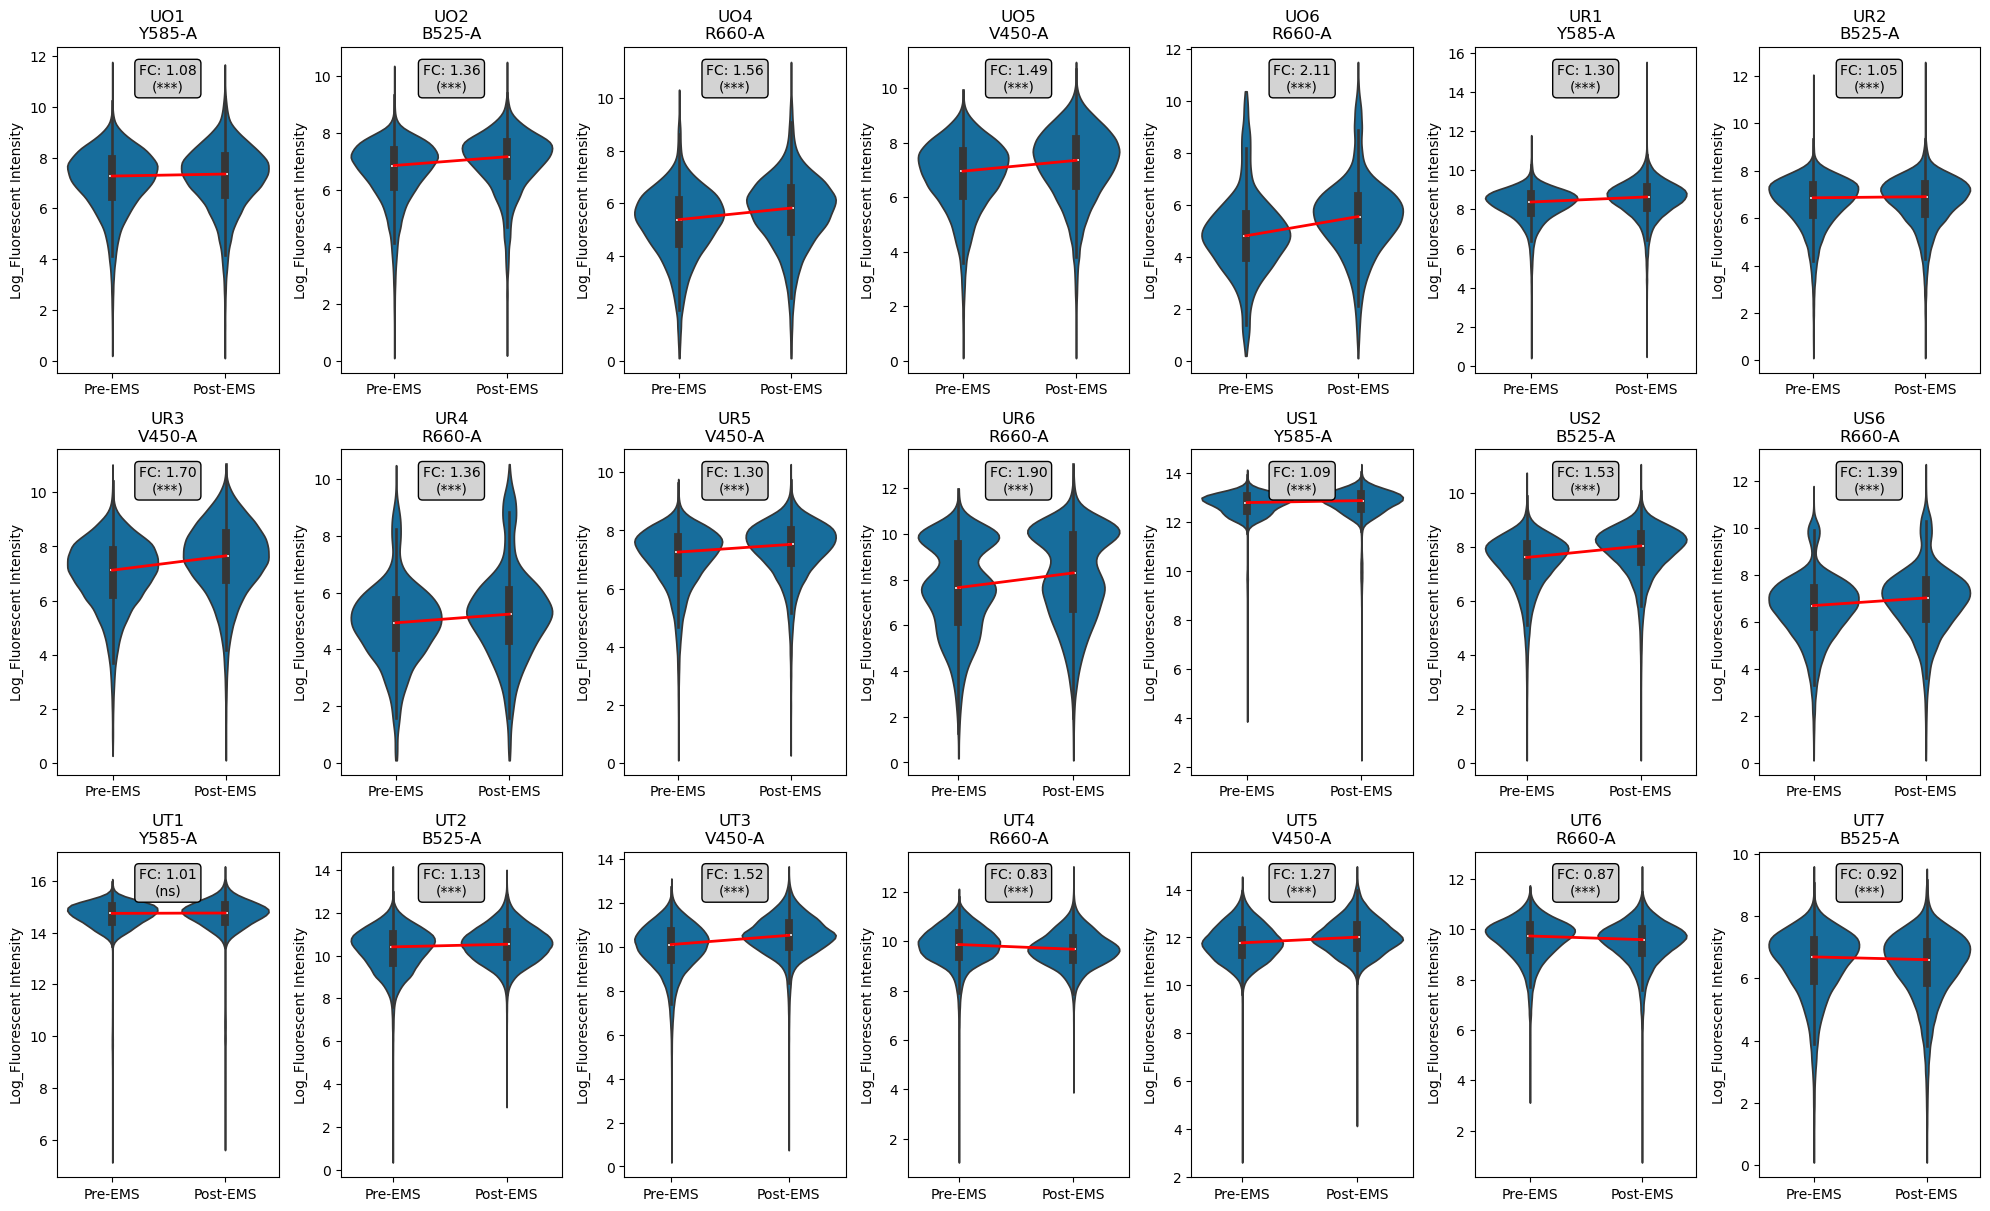

Summary plot saved


In [ ]:
# Cell 8: Create summary plot - only primary channels
def create_summary_plot(all_data, stats_df, output_folder):
    """Create summary plot - only show primary channel for each sample"""
    fig = plt.figure(figsize=(20, 16))
    gs = GridSpec(4, 7, figure=fig)  # 4 rows, 7 columns grid
    
    # Sort samples: first by folder, then by numbers in sample name
    all_samples = []
    for folder in ['a', 'b', 'c', 'd']:
        if folder in all_data:
            folder_samples = list(all_data[folder]['results'].keys())
            # Sort by numbers
            all_samples.extend([(folder, sample) for sample in folder_samples])
    
    all_samples.sort(key=lambda x: x[1])

    # Create plots
    for idx, (folder, sample_name) in enumerate(all_samples):
        if idx >= 28:  # Maximum 28 positions (4x7)
            break
            
        sample_data = all_data[folder]['results'][sample_name]
        primary_channel = sample_data['pre'].get('primary_channel') or sample_data['post'].get('primary_channel')
        
        # Prepare data
        plot_data = []
        pre_values = sample_data['pre']['data'][primary_channel].values
        post_values = sample_data['post']['data'][primary_channel].values
        
        for value in pre_values:
            plot_data.append({
                'Value': np.log1p(value),
                'Condition': 'Pre-EMS'
            })
        
        for value in post_values:
            plot_data.append({
                'Value': np.log1p(value), 
                'Condition': 'Post-EMS'
            })
        
        plot_df = pd.DataFrame(plot_data)
        
        # Determine subplot position
        row = idx // 7
        col = idx % 7
        ax = fig.add_subplot(gs[row, col])
        
        # Plot violin plot
        sns.violinplot(data=plot_df, x='Condition', y='Value', ax=ax, cut=0)
        
        # Add median line
        pre_median = plot_df[plot_df['Condition'] == 'Pre-EMS']['Value'].median()
        post_median = plot_df[plot_df['Condition'] == 'Post-EMS']['Value'].median()
        ax.plot([0, 1], [pre_median, post_median], 'r-', lw=2)
        
        # Add title and annotation
        sample_stats = stats_df[
            (stats_df['Sample'] == sample_name) & 
            (stats_df['Channel'] == primary_channel)
        ].iloc[0]
        
        fc_text = f"FC: {sample_stats['Fold_Change']:.2f}"
        sig_text = f"({sample_stats['Significance']})"
        
        ax.set_xlabel('')
        ax.set_ylabel('Log_Fluorescent Intensity') 

        ax.set_title(f'{sample_name}\n{primary_channel}')
        ax.text(0.5, 0.95, f'{fc_text}\n{sig_text}', 
                transform=ax.transAxes, ha='center', va='top',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, "Summary_Plot_Primary_Channels_test.png"), dpi=300, bbox_inches='tight')
    plt.show()

# Create summary plot
create_summary_plot(all_data, stats_df, parent_folder)
print("Summary plot saved")

In [ ]:
# Cell 9: Display result summary
# Display first few rows of summary data
print("Sample Summary:")
print(summary_df.head())

print("\nStatistical Results Summary:")
print(stats_df.head())

# Save processed data
summary_df.to_csv(os.path.join(parent_folder, "sample_summary.csv"), index=False)
stats_df.to_csv(os.path.join(parent_folder, "statistical_results.csv"), index=False)

Sample Summary:
  Folder Sample Primary_Channel  Pre_Original  Pre_Filtered  Pre_Percentage  \
0      a    UO1          Y585-A         83924         42507       50.649397   
1      a    UO5          V450-A         99910         35178       35.209689   
2      a    UR3          V450-A         99048         42586       42.995315   
3      a    UT2          B525-A         97145         88265       90.859025   
4      a    UT3          V450-A         80849         72801       90.045641   

   Post_Original  Post_Filtered  Post_Percentage  \
0          99424          50972        51.267300   
1          99753          45521        45.633715   
2          99357          58170        58.546454   
3          99770          98779        99.006715   
4          99594          96262        96.654417   

                                   Background_Values  
0  {'FSC-A': 487046.90625, 'FSC-H': 475686.8125, ...  
1  {'FSC-A': 487046.90625, 'FSC-H': 475686.8125, ...  
2  {'FSC-A': 487046.90625, 'FSC

PermissionError: [Errno 13] Permission denied: 'D:/iGEM/湿实验/流式/Flow Cytometry\\statistical_results.csv'


--- A. Promoter and Fluorophore Type Contribution (Eta Squared) ---

--- Contribution Assessment (Non-parametric Eta Squared) ---
Promoter Contribution (Eta²): 0.0400
Fluorophore Type Contribution (Eta²): 0.5379

Assessment Summary:
- Promoter explains 4.00% of the Composite Score variance.
- Fluorophore Type explains 53.79% of the Composite Score variance.
Conclusion: A higher Eta² value indicates a greater contribution of the factor to the variation in the Composite Score.

--- B. Optimal Combination Selection ---

--- Optimal Combination (MAX Composite Score) ---
Best Promoter: R
Best Fluorophore Type: 3
---------------------------------------
Average Composite Score (S): 2289.77
Average Effectiveness (E) [Large & Significant Primary Channel Change]: 229.00
Average Specificity Loss (S_loss) [Small Change in Other Channels]: 0.2177
Average log2(FC): 0.763
---------------------------------------
Selection Rationale: This combination showed the largest, most significant change in the 

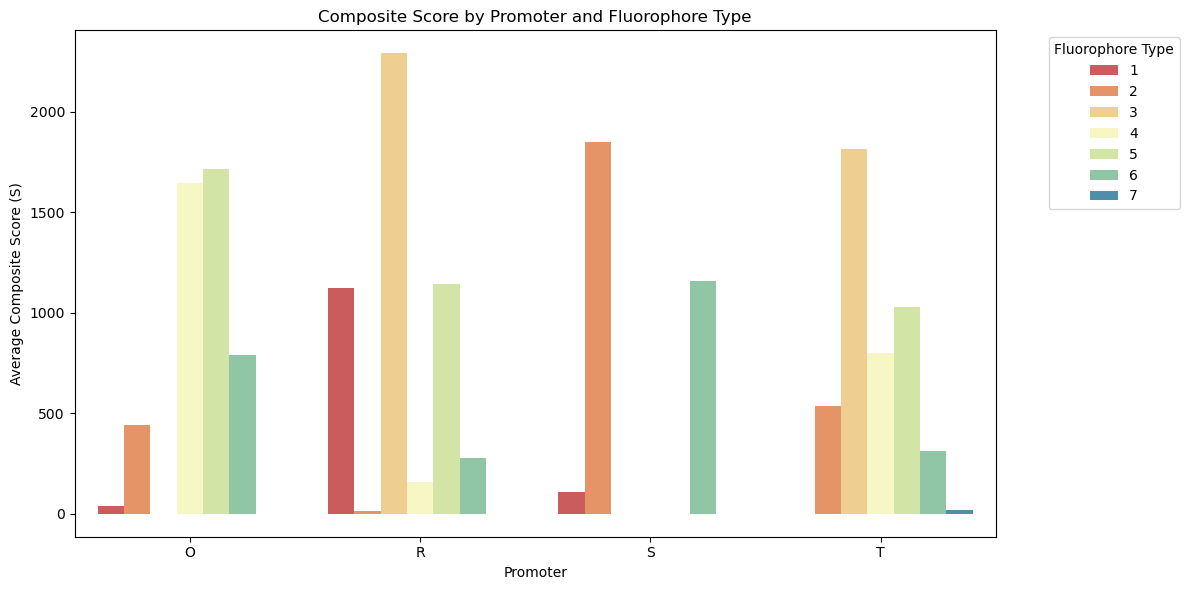

In [39]:
# Cell 10: MODEL ANALYSIS & OPTIMIZATION (FINAL FIXED VERSION WITH ETA SQUARED)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Critical Check: Ensure analysis_df exists ---
try:
    analysis_df
except NameError:
    print("FATAL ERROR: analysis_df is not defined.")
    print("Please successfully run Cell 5.5 (Composite Score calculation) first to generate analysis_df.")
    # Exit current Cell execution
    raise

# --- 0. Data Preprocessing and Cleaning ---
# Copy and clean data for analysis, ensuring Composite Score and categorical variables are not null
model_data = analysis_df[['Promoter', 'Fluorophore_Type', 'Composite_Score_S']].copy()
model_data = model_data[model_data['Promoter'] != 'Unknown'].dropna()

if model_data.empty:
    print("ERROR: Samples for analysis are empty after cleaning. Please ensure sample names include S, R, O, T and numbers 1-7.")


# --- A. Contribution Analysis (Eta Squared) ---
print("\n--- A. Promoter and Fluorophore Type Contribution (Eta Squared) ---")

def calculate_eta_squared(df, factor):
    """
    Calculates the contribution (Eta Squared) of a categorical factor 
    to the total variance of Composite_Score_S.
    Eta² = SS_factor / SS_total
    """
    if df.empty:
        return 0.0
    
    # Calculate Sum of Squares between groups (SS_factor)
    ss_factor = df.groupby(factor)['Composite_Score_S'].apply(
        lambda x: len(x) * (x.mean() - df['Composite_Score_S'].mean())**2
    ).sum()
    
    # Total Sum of Squares (SS_total)
    ss_total = ((df['Composite_Score_S'] - df['Composite_Score_S'].mean())**2).sum()
    
    # Return Eta Squared
    return ss_factor / ss_total if ss_total != 0 else 0.0

try:
    eta2_promoter = calculate_eta_squared(model_data, 'Promoter')
    eta2_fluorophore = calculate_eta_squared(model_data, 'Fluorophore_Type')

    print("\n--- Contribution Assessment (Non-parametric Eta Squared) ---")
    print(f"Promoter Contribution (Eta²): {eta2_promoter:.4f}")
    print(f"Fluorophore Type Contribution (Eta²): {eta2_fluorophore:.4f}")
    print("\nAssessment Summary:")
    print(f"- Promoter explains {eta2_promoter*100:.2f}% of the Composite Score variance.")
    print(f"- Fluorophore Type explains {eta2_fluorophore*100:.2f}% of the Composite Score variance.")
    print("Conclusion: A higher Eta² value indicates a greater contribution of the factor to the variation in the Composite Score.")

except Exception as e:
    print(f"\nNon-parametric Eta Squared assessment failed: {e}.")
    print("Contribution could not be assessed. Please check for data anomalies in model_data.")


# --- B. Optimal Combination Selection ---
print("\n--- B. Optimal Combination Selection ---")

# 1. Group by (Promoter, Fluorophore Type) and calculate the mean Composite Score
best_combination = analysis_df.groupby(['Promoter', 'Fluorophore_Type']).agg({
    'Composite_Score_S': 'mean',
    'Effectiveness_E': 'mean',
    'S_loss': 'mean',
    'log2_Fold_Change': 'mean'
}).reset_index()

# 2. Find the combination with the highest Composite Score
if not best_combination.empty:
    best_combo = best_combination.loc[best_combination['Composite_Score_S'].idxmax()]

    print("\n--- Optimal Combination (MAX Composite Score) ---")
    print(f"Best Promoter: {best_combo['Promoter']}")
    print(f"Best Fluorophore Type: {best_combo['Fluorophore_Type']}")
    print("---------------------------------------")
    print(f"Average Composite Score (S): {best_combo['Composite_Score_S']:.2f}")
    print(f"Average Effectiveness (E) [Large & Significant Primary Channel Change]: {best_combo['Effectiveness_E']:.2f}")
    print(f"Average Specificity Loss (S_loss) [Small Change in Other Channels]: {best_combo['S_loss']:.4f}")
    print(f"Average log2(FC): {best_combo['log2_Fold_Change']:.3f}")
    print("---------------------------------------")
    print("Selection Rationale: This combination showed the largest, most significant change in the Primary Channel with minimal non-specific changes in other channels, making it the optimal candidate for EMS treatment.")
else:
    print("\nERROR: Could not find the optimal combination as grouped data is empty or missing Composite Scores.")


# --- C. Visualization (Optional) ---
plt.figure(figsize=(12, 6))
# Ensure data for plotting only includes valid Promoters
plot_data = best_combination[best_combination['Promoter'] != 'Unknown'].copy()
plot_data['Fluorophore_Type'] = plot_data['Fluorophore_Type'].astype('category')

sns.barplot(
    data=plot_data, 
    x='Promoter', 
    y='Composite_Score_S', 
    hue='Fluorophore_Type',
    palette='Spectral'
)
plt.title('Composite Score by Promoter and Fluorophore Type')
plt.xlabel('Promoter')
plt.ylabel('Average Composite Score (S)')
plt.legend(title='Fluorophore Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()